# QEvasion – Transformer Fine-tuning (Clarity & Evasion)

In this notebook we fine-tune a pretrained transformer encoder on the QEvasion dataset
for the two main tasks:

- **Task 1 – Clarity-level classification (3-way)**  
  Labels: `clarity_label` → `clarity_id`

- **Task 2 – Evasion-level classification (9-way)**  
  Labels: `evasion_label` → `evasion_id` (on the train split)  
  + special **test evaluation** using annotators (`annotator1/2/3`).

We:
1. Load and preprocess the data.
2. Create train/validation/test splits.
3. Tokenize question–answer pairs with a pretrained tokenizer.
4. Fine-tune a transformer with a **manual PyTorch loop** (no `Trainer`).
5. Evaluate Task 1 on the official test split.
6. Train and evaluate Task 2, including test evaluation using annotators.

## 1. Imports & Setup

In [1]:
# If Colab, run this cell

!rm -rf political-evasion-classifier
!git clone https://github.com/minh-de-rien/political-evasion-classifier.git
%cd political-evasion-classifier

import sys
sys.path.insert(0, "/content/political-evasion-classifier")

Cloning into 'political-evasion-classifier'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 89 (delta 22), reused 80 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 4.50 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/political-evasion-classifier


In [ ]:
# If local, run this cell

import os
import sys
from pathlib import Path

# Add project root to path
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Import data utilities
from src.data import (
    load_qevasion_prepared,
    prepare_task1_data,
    prepare_task2_data,
    CLARITY_LABELS,
    EVASION_LABELS,
    CLARITY_TO_ID,
    EVASION_TO_ID,
    ID_TO_CLARITY,
    ID_TO_EVASION
)

# Import metrics utilities
from src.metrics import (
    evaluate_task1,
    evaluate_task2_standard,
    evaluate_task2_multi_annotator,
    plot_confusion_matrix,
    compute_per_class_metrics,
    majority_baseline_accuracy
)

# Import model architectures and losses
from src.models import (
    MultiTaskTransformer,
    FocalLoss
)

# Import training utilities
from src.training import (
    EarlyStopping,
    evaluate,
    evaluate_multitask,
    train_model
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 2. Configuration

In [6]:
# Model configuration
MODEL_NAME = "distilbert-base-uncased"  # Options: "roberta-base", "bert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

# Training configuration
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
PATIENCE = 3  # For early stopping

# Random seed for reproducibility
RANDOM_STATE = 42
VAL_SIZE = 0.1

print("Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Max Length: {MAX_LENGTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Max Epochs: {NUM_EPOCHS}")
print(f"  Early Stopping Patience: {PATIENCE}")

Configuration:
  Model: distilbert-base-uncased
  Max Length: 256
  Batch Size: 16
  Learning Rate: 2e-05
  Max Epochs: 5
  Early Stopping Patience: 3


## 3. Load & Explore Data

In [7]:
# Load dataset
dataset = load_qevasion_prepared()

# Prepare Task 1 (Clarity) data
clarity_train_df, clarity_val_df, clarity_test_df = prepare_task1_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

# Prepare Task 2 (Evasion) data
evasion_train_df, evasion_val_df, evasion_test_df = prepare_task2_data(
    dataset, val_size=VAL_SIZE, random_state=RANDOM_STATE
)

print("="*60)
print("TASK 1: CLARITY CLASSIFICATION")
print("="*60)
print(f"Train: {len(clarity_train_df)} examples")
print(f"Val:   {len(clarity_val_df)} examples")
print(f"Test:  {len(clarity_test_df)} examples")
print(f"\nLabels: {CLARITY_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(clarity_train_df['clarity_id'].values, clarity_test_df['clarity_id'].values):.4f}")

print("\n" + "="*60)
print("TASK 2: EVASION CLASSIFICATION")
print("="*60)
print(f"Train: {len(evasion_train_df)} examples")
print(f"Val:   {len(evasion_val_df)} examples")
print(f"Test:  {len(evasion_test_df)} examples (multi-annotator)")
print(f"\nLabels: {EVASION_LABELS}")
print(f"Majority Baseline Accuracy: {majority_baseline_accuracy(evasion_train_df['evasion_id'].values, evasion_val_df['evasion_id'].values):.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TASK 1: CLARITY CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples

Labels: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
Majority Baseline Accuracy: 0.6688

TASK 2: EVASION CLASSIFICATION
Train: 3103 examples
Val:   345 examples
Test:  308 examples (multi-annotator)

Labels: ['Claims ignorance', 'Clarification', 'Declining to answer', 'Deflection', 'Dodging', 'Explicit', 'General', 'Implicit', 'Partial/half-answer']
Majority Baseline Accuracy: 0.3043


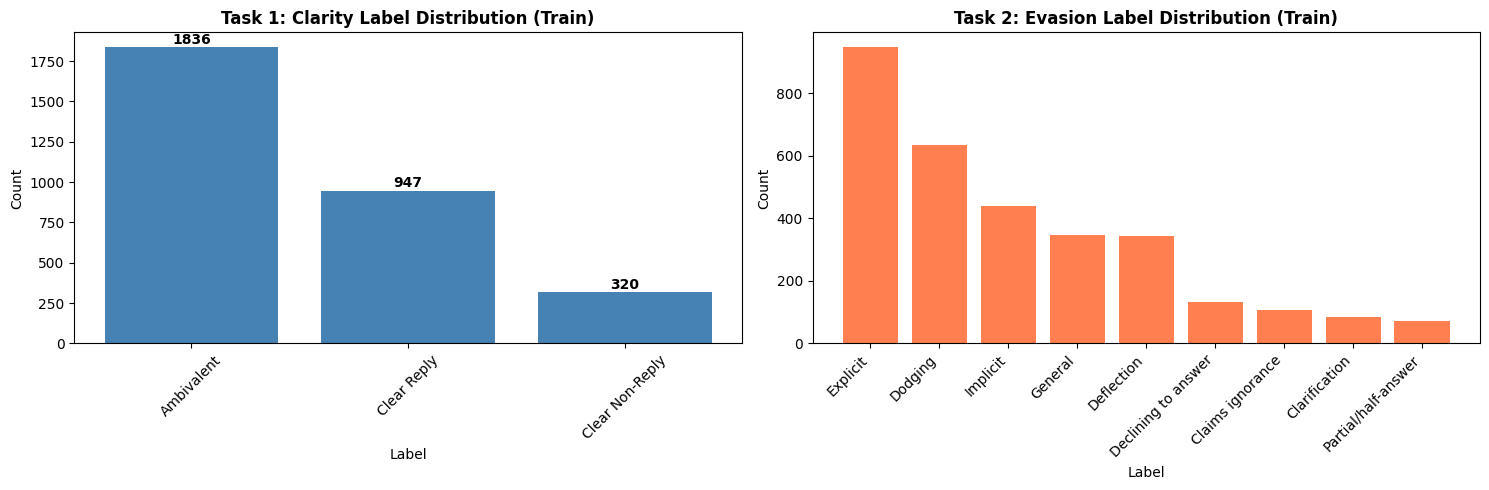

In [5]:
# Visualize label distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Clarity distribution
clarity_counts = clarity_train_df['clarity_label'].value_counts()
axes[0].bar(clarity_counts.index, clarity_counts.values, color='steelblue')
axes[0].set_title('Task 1: Clarity Label Distribution (Train)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(clarity_counts.values):
    axes[0].text(i, v + 20, str(v), ha='center', fontweight='bold')

# Evasion distribution
evasion_counts = evasion_train_df['evasion_label'].value_counts()
axes[1].bar(range(len(evasion_counts)), evasion_counts.values, color='coral')
axes[1].set_title('Task 2: Evasion Label Distribution (Train)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(evasion_counts)))
axes[1].set_xticklabels(evasion_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 4. Dataset & DataLoader Setup

In [8]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {len(tokenizer)}")

Tokenizer loaded: distilbert-base-uncased
Vocabulary size: 30522


In [4]:
class QEvasionDataset(Dataset):
    """PyTorch Dataset for QEvasion tasks."""

    def __init__(self, df, tokenizer, max_length, task='clarity'):
        """
        Args:
            df: DataFrame with text and labels
            tokenizer: HuggingFace tokenizer
            max_length: Maximum sequence length
            task: 'clarity', 'evasion', or 'multitask'
        """
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.task = task

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['text']

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

        # Add labels based on task
        if self.task == 'clarity':
            item['labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
        elif self.task == 'evasion':
            item['labels'] = torch.tensor(row['evasion_id'], dtype=torch.long)
        elif self.task == 'multitask':
            item['clarity_labels'] = torch.tensor(row['clarity_id'], dtype=torch.long)
            if 'evasion_id' in row and row['evasion_id'] != -1:
                item['evasion_labels'] = torch.tensor(row['evasion_id'], dtype=torch.long)
                item['evasion_mask'] = torch.tensor(1, dtype=torch.long)
            else:
                item['evasion_labels'] = torch.tensor(-1, dtype=torch.long)
                item['evasion_mask'] = torch.tensor(0, dtype=torch.long)

        return item

In [14]:
# Create DataLoaders for Task 1 (Clarity)
clarity_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task='clarity')
clarity_val_dataset = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task='clarity')
clarity_test_dataset = QEvasionDataset(clarity_test_df, tokenizer, MAX_LENGTH, task='clarity')

clarity_train_loader = DataLoader(clarity_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
clarity_val_loader = DataLoader(clarity_val_dataset, batch_size=BATCH_SIZE)
clarity_test_loader = DataLoader(clarity_test_dataset, batch_size=BATCH_SIZE)

print("Task 1 DataLoaders created:")
print(f"  Train batches: {len(clarity_train_loader)}")
print(f"  Val batches: {len(clarity_val_loader)}")
print(f"  Test batches: {len(clarity_test_loader)}")

Task 1 DataLoaders created:
  Train batches: 194
  Val batches: 22
  Test batches: 20


In [15]:
# Create DataLoaders for Task 2 (Evasion)
evasion_train_dataset = QEvasionDataset(evasion_train_df, tokenizer, MAX_LENGTH, task='evasion')
evasion_val_dataset = QEvasionDataset(evasion_val_df, tokenizer, MAX_LENGTH, task='evasion')

evasion_train_loader = DataLoader(evasion_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
evasion_val_loader = DataLoader(evasion_val_dataset, batch_size=BATCH_SIZE)

print("Task 2 DataLoaders created:")
print(f"  Train batches: {len(evasion_train_loader)}")
print(f"  Val batches: {len(evasion_val_loader)}")

Task 2 DataLoaders created:
  Train batches: 194
  Val batches: 22


## 5. Task 1: Clarity Classification

Train a transformer model to classify political responses into 3 clarity levels.

In [16]:
# Initialize Task 1 model
clarity_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(CLARITY_LABELS),
    id2label=ID_TO_CLARITY,
    label2id=CLARITY_TO_ID
).to(device)

# Setup optimizer and loss
clarity_optimizer = torch.optim.AdamW(clarity_model.parameters(), lr=LEARNING_RATE)
clarity_loss_fn = nn.CrossEntropyLoss()

# Early stopping
clarity_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING TASK 1: CLARITY CLASSIFICATION")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME}")
print(f"Parameters: {sum(p.numel() for p in clarity_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in clarity_model.parameters() if p.requires_grad):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING TASK 1: CLARITY CLASSIFICATION
Model: distilbert-base-uncased
Parameters: 66,955,779
Trainable: 66,955,779


In [17]:
# Train Task 1
clarity_history = train_model(
    model=clarity_model,
    train_loader=clarity_train_loader,
    val_loader=clarity_val_loader,
    optimizer=clarity_optimizer,
    scheduler=None,
    clarity_loss_fn=clarity_loss_fn,
    evasion_loss_fn=clarity_loss_fn,  # Reuse for single-task
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=clarity_early_stopping,
    verbose=True,
    is_multitask=False
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 0.8892
Val Accuracy: 0.6319
Val Macro F1: 0.4588

Epoch 2/5
------------------------------------------------------------
Train Loss: 0.7931
Val Accuracy: 0.6464
Val Macro F1: 0.5565
Metric improved from 0.4588 to 0.5565

Epoch 3/5
------------------------------------------------------------
Train Loss: 0.6801
Val Accuracy: 0.6696
Val Macro F1: 0.5947
Metric improved from 0.5565 to 0.5947

Epoch 4/5
------------------------------------------------------------
Train Loss: 0.5944
Val Accuracy: 0.6464
Val Macro F1: 0.5844
No improvement for 1 epoch(s)

Epoch 5/5
------------------------------------------------------------
Train Loss: 0.5133
Val Accuracy: 0.6754
Val Macro F1: 0.6137
Metric improved from 0.5947 to 0.6137


In [18]:
# Evaluate Task 1 on test set
print(f"\n{'='*60}")
print("TASK 1: TEST SET EVALUATION")
print(f"{'='*60}\n")

test_metrics, test_preds, test_labels, test_logits = evaluate(
    clarity_model, clarity_test_loader, device, return_predictions=True
)

# Comprehensive metrics
evaluate_task1(
    y_true=test_labels,
    y_pred=test_preds,
    label_names=CLARITY_LABELS,
    verbose=True
)


TASK 1: TEST SET EVALUATION

TASK 1: CLARITY CLASSIFICATION
Accuracy:          0.6916
Macro F1:          0.5252
Weighted F1:       0.6619
Macro Precision:   0.6030
Macro Recall:      0.4972

Classification Report:
                 precision    recall  f1-score   support

     Ambivalent       0.73      0.88      0.80       206
Clear Non-Reply       0.54      0.30      0.39        23
    Clear Reply       0.55      0.30      0.39        79

       accuracy                           0.69       308
      macro avg       0.60      0.50      0.53       308
   weighted avg       0.67      0.69      0.66       308



{'accuracy': 0.6915584415584416,
 'macro_f1': 0.5252105657453364,
 'weighted_f1': 0.6618587251759586,
 'macro_precision': 0.6030052285032365,
 'macro_recall': 0.49721348002415167}

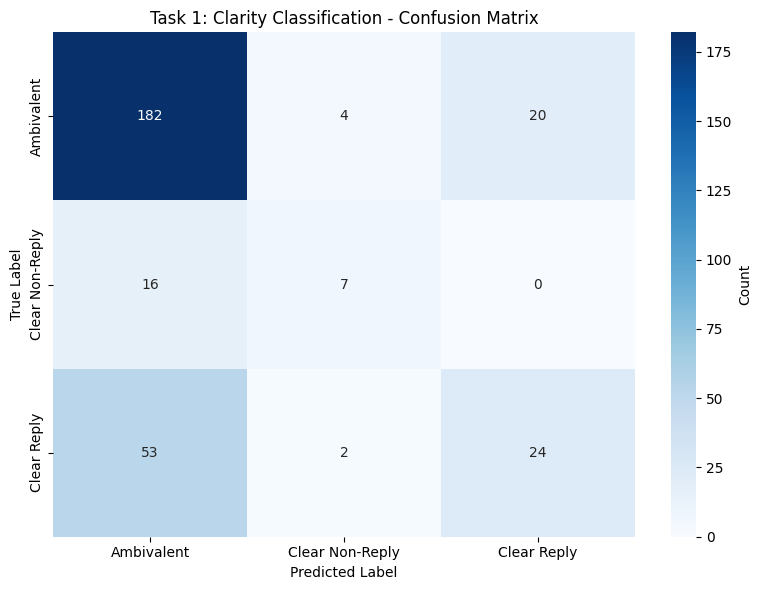

In [19]:
# Confusion matrix for Task 1
plot_confusion_matrix(
    y_true=test_labels,
    y_pred=test_preds,
    label_names=CLARITY_LABELS,
    title="Task 1: Clarity Classification - Confusion Matrix",
    figsize=(8, 6)
)

In [20]:
# Per-class metrics
per_class_df = compute_per_class_metrics(test_labels, test_preds, CLARITY_LABELS)
print("\nPer-Class Performance:")
print(per_class_df.to_string(index=False))


Per-Class Performance:
          Label  Support  Precision   Recall       F1
     Ambivalent      206   0.725100 0.883495 0.796499
Clear Non-Reply       23   0.538462 0.304348 0.388889
    Clear Reply       79   0.545455 0.303797 0.390244


## 6. Task 2: Evasion Classification

Train a transformer model to classify evasion types (9 classes).

**Note:** Test evaluation uses multi-annotator agreement - a prediction is correct if it matches ANY annotator label.

In [21]:
# Initialize Task 2 model
evasion_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(EVASION_LABELS),
    id2label=ID_TO_EVASION,
    label2id=EVASION_TO_ID
).to(device)

# Setup optimizer and loss (use Focal Loss for imbalanced classes)
evasion_optimizer = torch.optim.AdamW(evasion_model.parameters(), lr=LEARNING_RATE)
evasion_loss_fn = FocalLoss(gamma=2.0)  # Helps with class imbalance

# Early stopping
evasion_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING TASK 2: EVASION CLASSIFICATION")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME}")
print(f"Loss Function: Focal Loss (gamma=2.0) - helps with class imbalance")
print(f"Parameters: {sum(p.numel() for p in evasion_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in evasion_model.parameters() if p.requires_grad):,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



TRAINING TASK 2: EVASION CLASSIFICATION
Model: distilbert-base-uncased
Loss Function: Focal Loss (gamma=2.0) - helps with class imbalance
Parameters: 66,960,393
Trainable: 66,960,393


In [22]:
# Train Task 2
evasion_history = train_model(
    model=evasion_model,
    train_loader=evasion_train_loader,
    val_loader=evasion_val_loader,
    optimizer=evasion_optimizer,
    scheduler=None,
    clarity_loss_fn=evasion_loss_fn,
    evasion_loss_fn=evasion_loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=evasion_early_stopping,
    verbose=True,
    is_multitask=False
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 1.8782
Val Accuracy: 0.3217
Val Macro F1: 0.0836

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.7716
Val Accuracy: 0.3507
Val Macro F1: 0.1697
Metric improved from 0.0836 to 0.1697

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.6459
Val Accuracy: 0.3594
Val Macro F1: 0.2438
Metric improved from 0.1697 to 0.2438

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4883
Val Accuracy: 0.3681
Val Macro F1: 0.3288
Metric improved from 0.2438 to 0.3288

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.3211
Val Accuracy: 0.3623
Val Macro F1: 0.3375
Metric improved from 0.3288 to 0.3375


In [23]:
# Evaluate Task 2 on validation set (standard single-label)
print(f"\n{'='*60}")
print("TASK 2: VALIDATION SET EVALUATION")
print(f"{'='*60}\n")

val_metrics, val_preds, val_labels, _ = evaluate(
    evasion_model, evasion_val_loader, device, return_predictions=True
)

evaluate_task2_standard(
    y_true=val_labels,
    y_pred=val_preds,
    label_names=EVASION_LABELS,
    verbose=True
)


TASK 2: VALIDATION SET EVALUATION

TASK 2: EVASION CLASSIFICATION (Single Label)
Accuracy:          0.3623
Macro F1:          0.3375
Weighted F1:       0.3549
Macro Precision:   0.3537
Macro Recall:      0.3519

Classification Report:
                     precision    recall  f1-score   support

   Claims ignorance       0.42      0.42      0.42        12
      Clarification       0.57      0.89      0.70         9
Declining to answer       0.67      0.29      0.40        14
         Deflection       0.26      0.24      0.25        38
            Dodging       0.42      0.35      0.38        71
           Explicit       0.46      0.48      0.47       105
            General       0.13      0.10      0.12        39
           Implicit       0.24      0.41      0.31        49
Partial/half-answer       0.00      0.00      0.00         8

           accuracy                           0.36       345
          macro avg       0.35      0.35      0.34       345
       weighted avg       0.36

{'accuracy': 0.36231884057971014,
 'macro_f1': 0.3375225926340113,
 'weighted_f1': 0.3549214716298566,
 'macro_precision': 0.3537105928883172,
 'macro_recall': 0.35190471851667093}

### Task 2: Test Set Evaluation (Multi-Annotator)

The test set uses 3 annotators. A prediction is correct if it matches **ANY** annotator's label.

In [24]:
# Prepare test data for evasion (only examples with annotator labels)
test_evasion_with_labels = evasion_test_df[
    evasion_test_df['annotator_labels'].apply(len) > 0
].reset_index(drop=True)

print(f"Test examples with annotator labels: {len(test_evasion_with_labels)}")
print(f"Total test examples: {len(evasion_test_df)}")

# Create test dataset (use dummy labels since we'll compare to annotator sets)
test_evasion_dataset = QEvasionDataset(
    test_evasion_with_labels.assign(evasion_id=0),  # Dummy label
    tokenizer,
    MAX_LENGTH,
    task='evasion'
)
test_evasion_loader = DataLoader(test_evasion_dataset, batch_size=BATCH_SIZE)

Test examples with annotator labels: 308
Total test examples: 308


In [25]:
# Get predictions from model
evasion_model.eval()
test_pred_ids = []

with torch.no_grad():
    for batch in test_evasion_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = evasion_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_pred_ids.extend(preds.cpu().numpy())

# Convert predictions to label strings
test_pred_labels = [ID_TO_EVASION[pred_id] for pred_id in test_pred_ids]

# Get gold label sets (from annotators)
gold_label_sets = test_evasion_with_labels['annotator_labels'].tolist()

print(f"\n{'='*60}")
print("TASK 2: TEST SET EVALUATION (MULTI-ANNOTATOR)")
print(f"{'='*60}\n")

# Evaluate with multi-annotator metric
task2_test_metrics = evaluate_task2_multi_annotator(
    y_pred=test_pred_labels,
    gold_sets=gold_label_sets,
    verbose=True
)


TASK 2: TEST SET EVALUATION (MULTI-ANNOTATOR)

TASK 2: EVASION CLASSIFICATION (Multi-Annotator)
Total examples:    308
Correct:           128
Accuracy:          0.4156

Note: Prediction counted as correct if it matches ANY annotator.


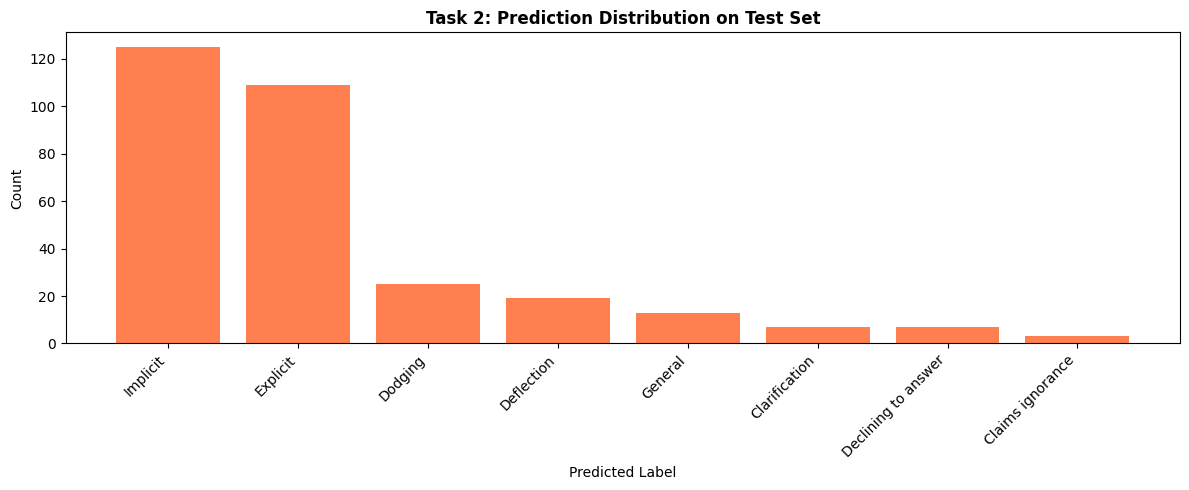


Test Set Prediction Counts:
Implicit               125
Explicit               109
Dodging                 25
Deflection              19
General                 13
Clarification            7
Declining to answer      7
Claims ignorance         3
Name: count, dtype: int64


In [26]:
# Analyze prediction distribution
pred_dist = pd.Series(test_pred_labels).value_counts()

plt.figure(figsize=(12, 5))
plt.bar(range(len(pred_dist)), pred_dist.values, color='coral')
plt.title('Task 2: Prediction Distribution on Test Set', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks(range(len(pred_dist)), pred_dist.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nTest Set Prediction Counts:")
print(pred_dist)

## 7. Multi-Task Learning

Train a single model that learns both clarity and evasion classification simultaneously.

In [9]:
# Create multi-task datasets
mt_train_dataset = QEvasionDataset(clarity_train_df, tokenizer, MAX_LENGTH, task='multitask')
mt_val_dataset = QEvasionDataset(clarity_val_df, tokenizer, MAX_LENGTH, task='multitask')

mt_train_loader = DataLoader(mt_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mt_val_loader = DataLoader(mt_val_dataset, batch_size=BATCH_SIZE)

print("Multi-Task DataLoaders created:")
print(f"  Train batches: {len(mt_train_loader)}")
print(f"  Val batches: {len(mt_val_loader)}")

Multi-Task DataLoaders created:
  Train batches: 194
  Val batches: 22


In [10]:
# Initialize multi-task model
mt_model = MultiTaskTransformer(
    model_name=MODEL_NAME,
    num_clarity_labels=len(CLARITY_LABELS),
    num_evasion_labels=len(EVASION_LABELS),
    dropout_rate=0.1
).to(device)

# Setup optimizer and losses
mt_optimizer = torch.optim.AdamW(mt_model.parameters(), lr=LEARNING_RATE)
mt_clarity_loss = nn.CrossEntropyLoss()
mt_evasion_loss = FocalLoss(gamma=2.0)  # Handle imbalance in evasion task

# Early stopping
mt_early_stopping = EarlyStopping(patience=PATIENCE, mode='max', verbose=True)

print(f"\n{'='*60}")
print("TRAINING MULTI-TASK MODEL")
print(f"{'='*60}")
print(f"Model: {MODEL_NAME} (shared encoder)")
print(f"Clarity Head: {len(CLARITY_LABELS)} classes")
print(f"Evasion Head: {len(EVASION_LABELS)} classes")
print(f"Total Parameters: {sum(p.numel() for p in mt_model.parameters()):,}")
print(f"Trainable: {sum(p.numel() for p in mt_model.parameters() if p.requires_grad):,}")


TRAINING MULTI-TASK MODEL
Model: distilbert-base-uncased (shared encoder)
Clarity Head: 3 classes
Evasion Head: 9 classes
Total Parameters: 66,372,108
Trainable: 66,372,108


In [11]:
# Train multi-task model
mt_history = train_model(
    model=mt_model,
    train_loader=mt_train_loader,
    val_loader=mt_val_loader,
    optimizer=mt_optimizer,
    scheduler=None,
    clarity_loss_fn=mt_clarity_loss,
    evasion_loss_fn=mt_evasion_loss,
    device=device,
    num_epochs=NUM_EPOCHS,
    early_stopping=mt_early_stopping,
    verbose=True,
    is_multitask=True
)


Epoch 1/5
------------------------------------------------------------
Train Loss: 2.2379
Val Accuracy: 0.6058
Val Macro F1: 0.4048

Epoch 2/5
------------------------------------------------------------
Train Loss: 1.9406
Val Accuracy: 0.6406
Val Macro F1: 0.5378
Metric improved from 0.4048 to 0.5378

Epoch 3/5
------------------------------------------------------------
Train Loss: 1.6712
Val Accuracy: 0.6551
Val Macro F1: 0.6145
Metric improved from 0.5378 to 0.6145

Epoch 4/5
------------------------------------------------------------
Train Loss: 1.4129
Val Accuracy: 0.6783
Val Macro F1: 0.6149
Metric improved from 0.6145 to 0.6149

Epoch 5/5
------------------------------------------------------------
Train Loss: 1.2258
Val Accuracy: 0.6667
Val Macro F1: 0.6178
Metric improved from 0.6149 to 0.6178


In [12]:
# Evaluate multi-task model
print(f"\n{'='*60}")
print("MULTI-TASK MODEL: VALIDATION EVALUATION")
print(f"{'='*60}\n")

mt_val_metrics = evaluate_multitask(mt_model, mt_val_loader, device)

print("Clarity Task:")
print(f"  Accuracy: {mt_val_metrics['clarity_accuracy']:.4f}")
print(f"  Macro F1: {mt_val_metrics['clarity_macro_f1']:.4f}")
print(f"  Weighted F1: {mt_val_metrics['clarity_weighted_f1']:.4f}")

if 'evasion_accuracy' in mt_val_metrics:
    print("\nEvasion Task:")
    print(f"  Accuracy: {mt_val_metrics['evasion_accuracy']:.4f}")
    print(f"  Macro F1: {mt_val_metrics['evasion_macro_f1']:.4f}")
    print(f"  Weighted F1: {mt_val_metrics['evasion_weighted_f1']:.4f}")


MULTI-TASK MODEL: VALIDATION EVALUATION

Clarity Task:
  Accuracy: 0.6667
  Macro F1: 0.6178
  Weighted F1: 0.6603

Evasion Task:
  Accuracy: 0.3971
  Macro F1: 0.3472
  Weighted F1: 0.3731


## 8. Training History Visualization

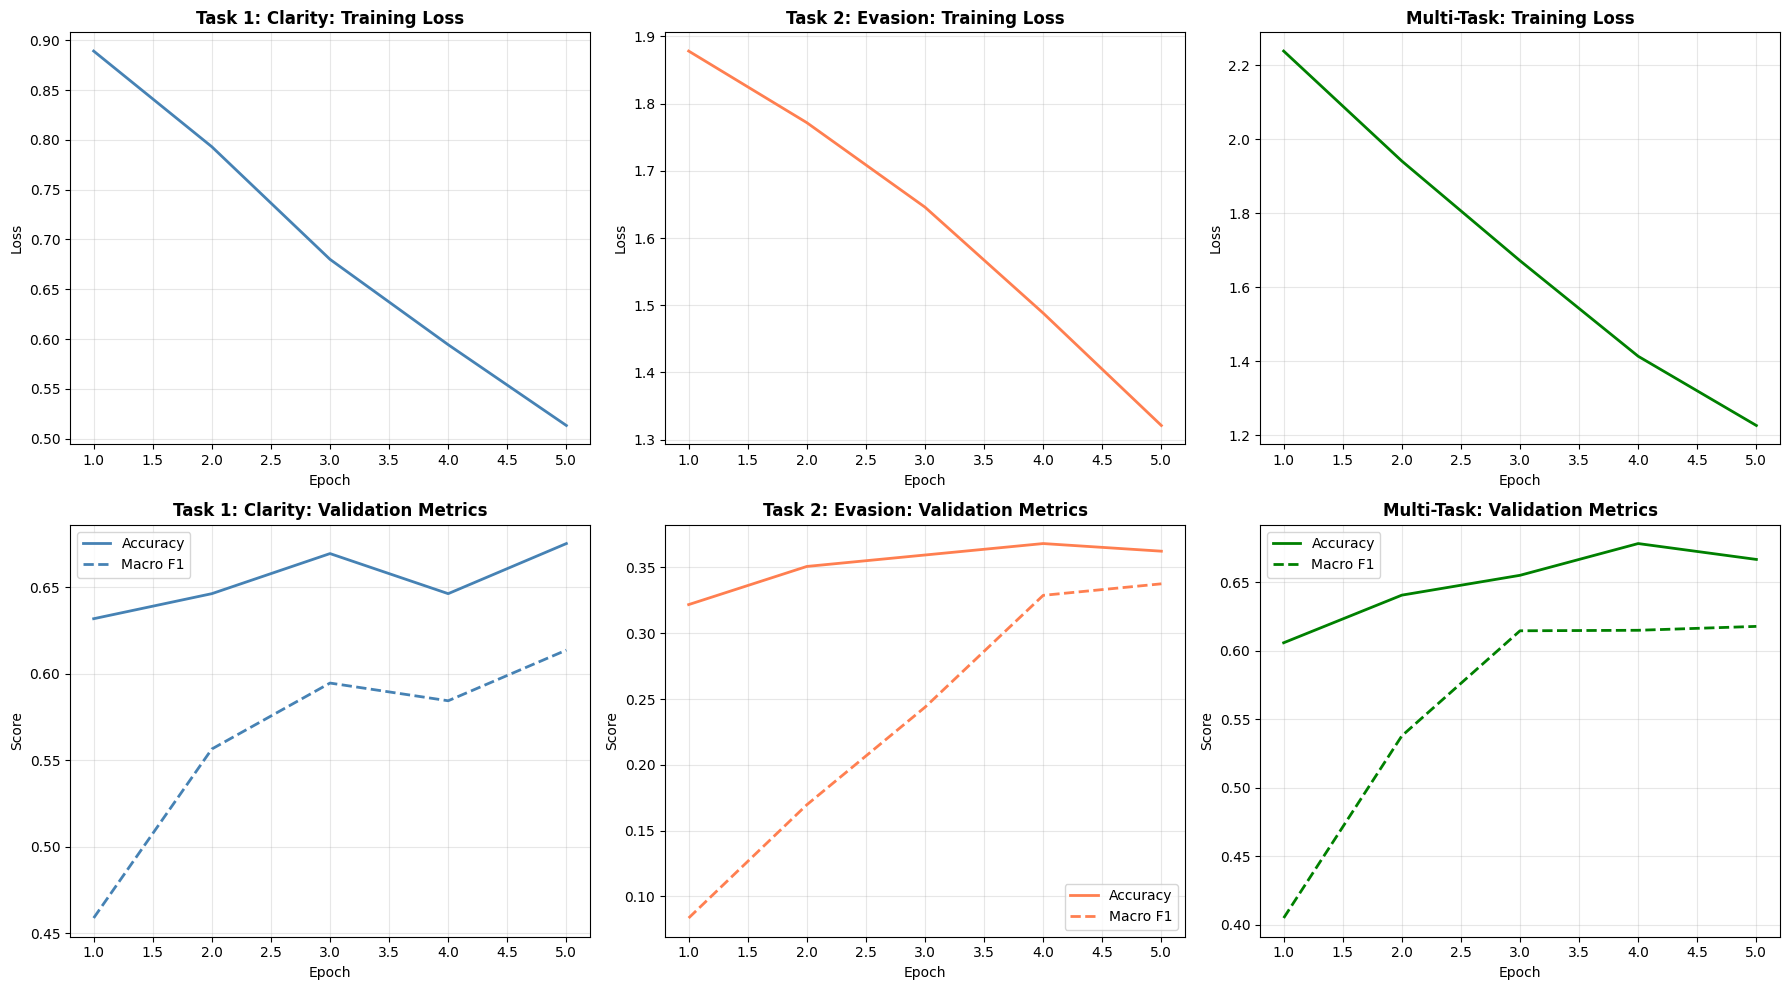

In [27]:
# Plot training histories
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [
    (clarity_history, 'Task 1: Clarity', 'steelblue'),
    (evasion_history, 'Task 2: Evasion', 'coral'),
    (mt_history, 'Multi-Task', 'green')
]

for idx, (history, title, color) in enumerate(histories):
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0, idx].plot(epochs, history['train_loss'], color=color, linewidth=2)
    axes[0, idx].set_title(f'{title}: Training Loss', fontweight='bold')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].grid(True, alpha=0.3)

    # Metrics plot
    axes[1, idx].plot(epochs, history['val_accuracy'], label='Accuracy', color=color, linewidth=2)
    axes[1, idx].plot(epochs, history['val_macro_f1'], label='Macro F1', color=color,
                     linestyle='--', linewidth=2)
    axes[1, idx].set_title(f'{title}: Validation Metrics', fontweight='bold')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Score')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Final Results Summary

In [29]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n📊 TASK 1: CLARITY CLASSIFICATION (Test Set)")
print("-" * 70)
print(f"  Accuracy:     {test_metrics['accuracy']:.4f}")
print(f"  Macro F1:     {test_metrics['macro_f1']:.4f}")
print(f"  Weighted F1:  {test_metrics['weighted_f1']:.4f}")
print(f"  Baseline:     {majority_baseline_accuracy(clarity_train_df['clarity_id'].values, clarity_test_df['clarity_id'].values):.4f}")

print("\n📊 TASK 2: EVASION CLASSIFICATION (Test Set, Multi-Annotator)")
print("-" * 70)
print(f"  Accuracy (any annotator): {task2_test_metrics['accuracy_any_annotator']:.4f}")
print(f"  Test examples:            {len(test_evasion_with_labels)}")

print("\n📊 MULTI-TASK MODEL (Validation Set)")
print("-" * 70)
print(f"  Clarity Accuracy:  {mt_val_metrics['clarity_accuracy']:.4f}")
print(f"  Clarity Macro F1:  {mt_val_metrics['clarity_macro_f1']:.4f}")
if 'evasion_accuracy' in mt_val_metrics:
    print(f"  Evasion Accuracy:  {mt_val_metrics['evasion_accuracy']:.4f}")
    print(f"  Evasion Macro F1:  {mt_val_metrics['evasion_macro_f1']:.4f}")


FINAL RESULTS SUMMARY

📊 TASK 1: CLARITY CLASSIFICATION (Test Set)
----------------------------------------------------------------------
  Accuracy:     0.6916
  Macro F1:     0.5252
  Weighted F1:  0.6619
  Baseline:     0.6688

📊 TASK 2: EVASION CLASSIFICATION (Test Set, Multi-Annotator)
----------------------------------------------------------------------
  Accuracy (any annotator): 0.4156
  Test examples:            308

📊 MULTI-TASK MODEL (Validation Set)
----------------------------------------------------------------------
  Clarity Accuracy:  0.6667
  Clarity Macro F1:  0.6178
  Evasion Accuracy:  0.3971
  Evasion Macro F1:  0.3472


## 10. Model Comparison

Compare single-task vs multi-task approaches.

In [31]:
# Create comparison DataFrame
comparison_data = {
    'Model': ['Task 1 (Single)', 'Task 2 (Single)', 'Multi-Task'],
    'Clarity Acc': [
        test_metrics['accuracy'],
        '-',
        mt_val_metrics['clarity_accuracy']
    ],
    'Clarity F1': [
        test_metrics['macro_f1'],
        '-',
        mt_val_metrics['clarity_macro_f1']
    ],
    'Evasion Acc': [
        '-',
        task2_test_metrics['accuracy_any_annotator'],
        mt_val_metrics.get('evasion_accuracy', '-')
    ],
    'Parameters': [
        f"{sum(p.numel() for p in clarity_model.parameters()):,}",
        f"{sum(p.numel() for p in evasion_model.parameters()):,}",
        f"{sum(p.numel() for p in mt_model.parameters()):,}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
          Model Clarity Acc Clarity F1 Evasion Acc Parameters
Task 1 (Single)    0.691558   0.525211           - 66,955,779
Task 2 (Single)           -          -    0.415584 66,960,393
     Multi-Task    0.666667   0.617759    0.397101 66,372,108
